# Radar graph

In [12]:
import numpy as np
import textwrap
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import math
import pandas as pd

https://towardsdatascience.com/how-to-create-and-visualize-complex-radar-charts-f7764d0f3652

https://colab.research.google.com/drive/1YftqOtPkJGIKbPqBQtjyZgikx20G7Z0M?usp=sharing#scrollTo=Jbxbe3jSyv9Z

In [2]:
class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable
    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True):
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], polar=True, label = "axes{}".format(i)) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=False)
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, labels=gridlabel, angle=angles[j])
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid()
        self.ax.xaxis.grid()

        # Draw outer circle
        self.ax.spines['polar'].set_visible(True)
        
        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, 15, 
                                          break_long_words=False)) for l in labels]
        self.ax.set_xticklabels(labels)
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            if a == 0:
                t.set_ha('center')
            elif a > 0 and a < 180:
                t.set_ha('left')
            elif a == 180:
                t.set_ha('center')
            else:
                t.set_ha('right')

        self.ax.tick_params(axis='both', pad=15)


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
    
    def fill_between(self, data, *args, **kwargs):
        """Plots an area"""
        sdata1 = self._scale_data(data[0], self.ranges)
        sdata2 = self._scale_data(data[1], self.ranges)
        self.ax1.fill_between(self.angle, np.r_[sdata1, sdata1[0]], np.r_[sdata2, sdata2[0]], *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)

In [2]:
data = pd.read_csv("acea_svi_results.csv")

In [4]:
data.head(3)

,Name,Agent,State,Notes,User,Tags,Created,Runtime,Sweep,activation,...,s_mse,s_new_cal_error,s_new_cov,s_new_crps,s_new_mse,s_new_width,s_train_time,s_width,train_time,white
0,firm-sweep-303,13191fhd,finished,-,michele-uit,NaN,2023-03-30T23:27:40.000Z,54,c657qoid,tanh,...,0.149754,0.002584,0.111494,0.056838,0.837616,1.146401,0.155830,0.565141,NaN,NaN
1,jumping-sweep-79,13191fhd,finished,-,michele-uit,NaN,2023-03-30T12:23:20.000Z,53,c657qoid,relu,...,0.116027,0.011761,0.064354,0.062513,0.798454,0.461836,0.172936,0.211113,NaN,NaN
2,stellar-sweep-110,13191fhd,finished,-,michele-uit,NaN,2023-03-30T13:57:14.000Z,51,c657qoid,relu,...,0.174039,0.019609,0.153508,0.071338,0.734358,1.209354,0.153755,0.572974,NaN,NaN


In [5]:
data.describe()

,Tags,Runtime,dropout_p,input_scaling,lr,num_chains,num_iterations,num_samples,seed,spectral_radius,...,s_mse,s_new_cal_error,s_new_cov,s_new_crps,s_new_mse,s_new_width,s_train_time,s_width,train_time,white
count,0.0,10.000000,10.0,0.0,10.000000,10.0,10.0,10.0,10.0,0.0,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,NaN,52.900000,0.0,NaN,0.053110,10.0,500.0,1000.0,10.0,NaN,...,0.185937,0.012164,0.107067,0.078598,1.239829,1.105039,0.159120,0.558497,NaN,NaN
std,NaN,1.197219,0.0,NaN,0.015053,0.0,0.0,0.0,0.0,NaN,...,0.040265,0.005878,0.027246,0.014784,0.515979,0.334078,0.009768,0.169233,NaN,NaN
min,NaN,51.000000,0.0,NaN,0.030547,10.0,500.0,1000.0,10.0,NaN,...,0.116027,0.002584,0.064354,0.056838,0.422742,0.461836,0.143522,0.211113,NaN,NaN
25%,NaN,52.250000,0.0,NaN,0.040245,10.0,500.0,1000.0,10.0,NaN,...,0.163035,0.008275,0.089795,0.066413,0.808244,1.013761,0.154274,0.505912,NaN,NaN
50%,NaN,53.000000,0.0,NaN,0.055024,10.0,500.0,1000.0,10.0,NaN,...,0.182927,0.011060,0.106544,0.083131,1.294132,1.102564,0.158191,0.569058,NaN,NaN
75%,NaN,54.000000,0.0,NaN,0.063508,10.0,500.0,1000.0,10.0,NaN,...,0.212901,0.017356,0.115646,0.084802,1.714082,1.193616,0.163263,0.612800,NaN,NaN
max,NaN,54.000000,0.0,NaN,0.074206,10.0,500.0,1000.0,10.0,NaN,...,0.245610,0.020233,0.153508,0.106481,1.813408,1.765293,0.174624,0.881773,NaN,NaN


In [3]:
variable = data.describe()[["m_cal_error","m_width","m_cov","m_mse","m_crps"]].T[["mean"]]
variable1 = data.describe()[["m_cal_error","m_width","m_cov","m_mse","m_crps"]].T[["min","max"]]
variable2 = data.describe()[["m_new_cal_error","m_new_width","m_new_cov","m_new_mse","m_new_crps"]].rename(columns={'m_new_cal_error':'m_cal_error','m_new_width':'m_width','m_new_cov':'m_cov','m_new_mse':'m_mse','m_new_crps':'m_crps'}).T[["min","max"]]

In [4]:
min_max_per_variable = variable1.copy()

In [8]:
variable1

,min,max
m_cal_error,1.183401,2.217376
m_width,2.413929,3.095649
m_cov,0.969045,0.981202
m_mse,0.238281,0.371833
m_crps,0.278214,0.339566


In [9]:
variable2

,min,max
m_cal_error,0.007193,0.021401
m_width,2.869251,4.066238
m_cov,0.940963,0.959266
m_mse,0.752395,2.128568
m_crps,0.274611,0.338097


In [15]:
variable

,mean
m_cal_error,1.830282
m_width,2.835560
m_cov,0.975118
m_mse,0.299564
m_crps,0.311240


In [5]:
min_max_per_variable["min"] = np.minimum(variable1["min"], variable2["min"]).apply(lambda x: int(x))
min_max_per_variable["max"] = np.maximum(variable1["max"], variable2["max"]).apply(lambda x: math.ceil(x))

In [11]:
min_max_per_variable

,min,max
m_cal_error,0,3
m_width,2,5
m_cov,0,1
m_mse,0,3
m_crps,0,1


In [6]:
result = variable.copy()
# result['min2'] = variable2['min']
# result['max2'] = variable2['max']
result = result.T

In [19]:
result

,m_cal_error,m_width,m_cov,m_mse,m_crps
mean,1.830282,2.83556,0.975118,0.299564,0.31124


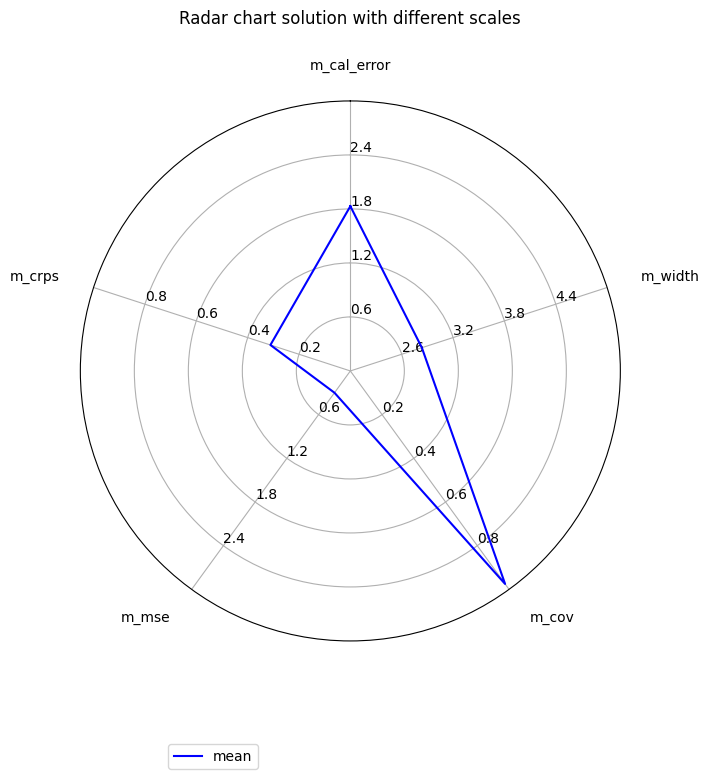

In [20]:
variables = result.columns
ranges = list(min_max_per_variable.itertuples(index=False, name=None))

fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges, show_scales=True)

colors = ['b','b','r','r']

for g in range(0, len(result.index), 2):
    # label = "pre-calibration" if g<2 else "post-calibration"
    label = "mean"
    radar.plot(result.loc[result.index[g]].values, label=label, color=colors[g])
    # radar.plot(result.loc[result.index[g+1]].values, label='_nolegend_', color=colors[g])
    # radar.fill_between((result.loc[result.index[g]].values,result.loc[result.index[g+1]].values), facecolor=colors[g], alpha=0.25, label='_nolegend_')

radar.set_title("Radar chart solution with different scales")
radar.use_legend(loc='lower left', bbox_to_anchor=(0.15, -0.25),ncol=radar.plot_counter)
plt.show()

# Parallel coordinates

https://en.wikipedia.org/wiki/Parallel_coordinates

https://stackoverflow.com/a/60401570

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import pandas as pd

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 18

In [2]:
# SVI acea
data = {"min":[0.39351414381897054-0.010048216968355686, 0.32050878954054074-0.0029827585759533504, 0.5681579855818824-0.04871366099546248, 3.10895919123352-0.012750511844521374, 0.9666283084004604-0.0013534544506618434],
        "max":[0.39351414381897054+0.010048216968355686, 0.32050878954054074+0.0029827585759533504, 0.5681579855818824+0.04871366099546248, 3.10895919123352+0.012750511844521374, 0.9666283084004604+0.0013534544506618434],
        "min2":[0.39068762249360134-0.0090957195371046, 0.3335404304320191-0.005057308190339864, 0.01715428556147478-0.003619548010940952, 2.890194583397649-0.047985924998171385, 0.9607978519370924-0.003236901334835418],
        "max2":[0.39068762249360134+0.0090957195371046, 0.3335404304320191+0.005057308190339864, 0.01715428556147478+0.003619548010940952, 2.890194583397649+0.047985924998171385, 0.9607978519370924+0.003236901334835418]}

In [6]:
# SVI SPAIN
data = {"min":[0.45321007119598394-0.048050369710414736, 0.3879571347592224-0.02305707237302801, 0.5281323209757274-0.2797781446284038, 3.5527213212733506-0.09397552094984822, 0.972087912087912-0.0034119065266505423],
        "max":[0.45321007119598394+0.048050369710414736, 0.3879571347592224+0.02305707237302801, 0.5281323209757274+0.2797781446284038, 3.5527213212733506+0.09397552094984822, 0.972087912087912+0.0034119065266505423],
        "min2":[0.42010463607927584-0.006629146517314301, 0.39456997621794426-0.017720029430451447, 0.0741081209998792-0.008676188586240665, 3.0942798341735593-0.0845664568783579, 0.9553846153846154-0.0035506581145941965],
        "max2":[0.42010463607927584+0.006629146517314301, 0.39456997621794426+0.017720029430451447, 0.0741081209998792+0.008676188586240665, 3.0942798341735593+0.0845664568783579, 0.9553846153846154+0.0035506581145941965]}

In [10]:
# dropout acea run 8420
data = {"min":[0.5786273651142643-0.11205992815962186, 0.20118250074711308-0.01721450728978099, 5.455590414514022-0.4538402397360632, 0.32467044780071236-0.03504243423289656, 0.1483241037598368-0.03034951868109081],
        "max":[0.5786273651142643+0.11205992815962186, 0.20118250074711308+0.01721450728978099, 5.455590414514022+0.4538402397360632, 0.32467044780071236+0.03504243423289656, 0.1483241037598368+0.03034951868109081],
        "min2":[0.568860429367499-0.1176646383694355, 0.19741196401739125-0.01787305125084482, 4.431585785045245-0.31774152183359183, 0.5151175602418496-0.05362643625547348, 0.2189449140192364-0.040286043886622304],
        "max2":[0.568860429367499+0.1176646383694355, 0.19741196401739125+0.01787305125084482, 4.431585785045245+0.31774152183359183, 0.5151175602418496+0.05362643625547348, 0.2189449140192364+0.040286043886622304]}

In [14]:
# dropout spain run 295
data = {"min":[0.8638325889008872-0.039353342834888845, 0.2623567270937137-0.015045107136093716, 2.4330950307933827-0.14862111584505086, 0.4823021779509421-0.03493662232516165, 0.24505494505494507-0.019065221508678537],
        "max":[0.8638325889008872+0.039353342834888845, 0.2623567270937137+0.015045107136093716, 2.4330950307933827+0.14862111584505086, 0.4823021779509421+0.03493662232516165, 0.24505494505494507+0.019065221508678537],
        "min2":[0.8942573378050873-0.04857497856158323, 0.25878355452689095-0.014572722025272116, 1.161634120275329-0.16811164256963806, 0.788664279520898-0.058197380723722526, 0.381978021978022-0.02997080252084534],
        "max2":[0.8942573378050873+0.04857497856158323, 0.25878355452689095+0.014572722025272116, 1.161634120275329+0.16811164256963806, 0.788664279520898+0.058197380723722526, 0.381978021978022+0.02997080252084534]}

In [18]:
# mcmc no dim red acea
data = {"min":[0.6853621889462517-0.3998218091443045, 0.6729795458797574-0.12378335592579016, 1.6987378703619616-0.5369542193946607, 9.642484960666044-5.123982614910528, 0.9945788399883416-0.004325411007657034],
        "max":[0.6853621889462517+0.3998218091443045, 0.6729795458797574+0.12378335592579016, 1.6987378703619616+0.5369542193946607, 9.642484960666044+5.123982614910528, 0.9945788399883416+0.004325411007657034],
        "min2":[0.707030910018669-0.47630336249310257, 0.47630336249310257-0.14460206269302472, 1.7032193354545675-1.1188827402662456, 3.1518782683926263-0.6955318873992726, 0.8087438064704168-0.16675369945333146],
        "max2":[0.707030910018669+0.47630336249310257, 0.47630336249310257+0.14460206269302472, 1.7032193354545675+1.1188827402662456, 3.1518782683926263+0.6955318873992726, 0.8087438064704168+0.16675369945333146]}

In [22]:
# mcmc no dim red spain
data = {"min":[1.02150052606676-1.0721657761277148, 0.57977440031648-0.23725837307203929, 0.4388813850984182-0.29779958572015247, 5.945067623654076-2.886546283922636, 0.9661538461538464-0.020877964109077683],
        "max":[1.02150052606676+1.0721657761277148, 0.57977440031648+0.23725837307203929, 0.4388813850984182+0.29779958572015247, 5.945067623654076+2.886546283922636, 0.9661538461538464+0.020877964109077683],
        "min2":[0.9183253835148952-0.8763384379637383, 0.621273701052542-0.2548547305348419, 0.052897325202270216-0.02825691912645602, 4.279292378780376-1.4573465310773868, 0.9371428571428572-0.009282950365689144],
        "max2":[0.9183253835148952+0.8763384379637383, 0.621273701052542+0.2548547305348419, 0.052897325202270216+0.02825691912645602, 4.279292378780376+1.4573465310773868, 0.9371428571428572+0.009282950365689144]}

In [26]:
# mcmc with dim red acea
data = {"min":[0.6151270330230489-0.17363750577125237, 0.4400971670604122-0.10957709126541404, 0.4661018548752834-0.06348145338567912, 4.798745585001056-1.9731151681346808, 0.9779428571428572-0.01004833669294501],
        "max":[0.6151270330230489+0.17363750577125237, 0.4400971670604122+0.10957709126541404, 0.4661018548752834+0.06348145338567912, 4.798745585001056+1.9731151681346808, 0.9779428571428572+0.01004833669294501],
        "min2":[0.6131607988540126-0.17448636619978625, 0.4569209885096831-0.11427182172306984, 0.007581328798185935-0.0022130390909862155, 3.7224727277673777-0.6336275962066475, 0.9666666666666666-0.0027812132950009753],
        "max2":[0.6131607988540126+0.17448636619978625, 0.4569209885096831+0.11427182172306984, 0.007581328798185935+0.0022130390909862155, 3.7224727277673777+0.6336275962066475, 0.9666666666666666+0.0027812132950009753]}

In [30]:
# mcmc with dim red spain
data = {"min":[1.344013064098141-0.39730625660318847, 0.6817018786899769-0.14845452270820267, 0.0960364629875618-0.09892380202037555, 4.765569630118518-1.762706653063686, 0.9147252747252748-0.015689290811054708],
        "max":[1.344013064098141+0.39730625660318847, 0.6817018786899769+0.14845452270820267, 0.0960364629875618+0.09892380202037555, 4.765569630118518+1.762706653063686, 0.9147252747252748+0.015689290811054708],
        "min2":[1.3136794941714054-0.3397707789858541, 0.6632273285142156-0.12621475568567755, 0.014762220746286673-0.001871529857215856, 5.226294573225026-1.1304337116789105, 0.9424175824175824-0.012307692307692328],
        "max2":[1.3136794941714054+0.3397707789858541, 0.6632273285142156+0.12621475568567755, 0.014762220746286673+0.001871529857215856, 5.226294573225026+1.1304337116789105, 0.9424175824175824+0.012307692307692328]}

In [34]:
# ssvs acea
data = {"min":[1.3611559519786949-0.4342473694916216, 2.03364171275579-1.3133681549804117, 2.9474652023218946-0.7838872065567921, 3.0800878104909475-1.9317629603711608, 0.6532206353832702-0.2057733397151771],
        "max":[1.3611559519786949+0.4342473694916216, 2.03364171275579+1.3133681549804117, 2.9474652023218946+0.7838872065567921, 3.0800878104909475+1.9317629603711608, 0.6532206353832702+0.2057733397151771],
        "min2":[1.3640225310101548-0.4076562345030389, 1.7497273293830111-0.7929525812540993, 3.3312699396080157-0.0875386851413486, 2.269745713185531-0.9264549831381962, 0.5039930049548237-0.05630703605515333],
        "max2":[1.3640225310101548+0.4076562345030389, 1.7497273293830111+0.7929525812540993, 3.3312699396080157+0.0875386851413486, 2.269745713185531+0.9264549831381962, 0.5039930049548237+0.05630703605515333]}

In [38]:
# ssvs spain
data = {"min":[0.9819395641750092-0.2355960994869753, 0.7533900900300368-0.27643831240789307, 0.5083413537012437-0.35083652891259753, 8.133437336542064-9.202926035836835, 0.9367032967032968-0.025570179467690524],
        "max":[0.9819395641750092+0.2355960994869753, 0.7533900900300368+0.27643831240789307, 0.5083413537012437+0.35083652891259753, 8.133437336542064+9.202926035836835, 0.9367032967032968+0.025570179467690524],
        "min2":[0.8609646694983013-0.10182541280433284, 0.6555106672704099-0.23234885305130024, 0.02703402366863903-0.007300665058173293, 4.860272960919067-2.7956053175446343, 0.9309890109890112-0.005831428202822661],
        "max2":[0.8609646694983013+0.10182541280433284, 0.6555106672704099+0.23234885305130024, 0.02703402366863903+0.007300665058173293, 4.860272960919067+2.7956053175446343, 0.9309890109890112+0.005831428202822661]}

In [84]:
# qr acea run 269
data = {"min":[0.1061469316482544-0.001311422442086041, 0.1589135702952164-0.001720997326170403, 0.004482620456667341-0.0029866046108213825, 1.109632968902588-0.02835713326931, 0.9481164383561642-0.0026772455497547825],
        "max":[0.1061469316482544+0.001311422442086041, 0.1589135702952164+0.001720997326170403, 0.004482620456667341+0.0029866046108213825, 1.109632968902588+0.02835713326931, 0.9481164383561642+0.0026772455497547825],
        "min2":[2.1418845653533936-0.010754309594631197, 0.15966175896824708-0.0018204286334408033, 0.05055446887980743-0.0060317909804971, 1.1287903785705566-0.022074054926633835, 0.2952815829528158-0.006857237934147671],
        "max2":[2.1418845653533936+0.010754309594631197, 0.15966175896824708+0.0018204286334408033, 0.05055446887980743+0.0060317909804971, 1.1287903785705566+0.022074054926633835, 0.2952815829528158+0.006857237934147671]}

In [88]:
# qr spain run 115
data = {"min":[0.2905876636505127-0.002222273498773575, 0.28836314267836644-0.005496869946647081, 0.037646799903393355-0.00527976316236584, 1.739101767539978-0.04651648178696632, 0.9134065934065936-0.00805727594717509],
        "max":[0.2905876636505127+0.002222273498773575, 0.28836314267836644+0.005496869946647081, 0.037646799903393355+0.00527976316236584, 1.739101767539978+0.04651648178696632, 0.9134065934065936+0.00805727594717509],
        "min2":[2.3599467277526855-0.014605999924242496, 0.2886298550686862-0.005333103396233239, 0.028632049269411913-0.005054105325127367, 1.6742557287216189-0.050032779574394226, 0.4307692307692309-0.014906219743132464],
        "max2":[2.3599467277526855+0.014605999924242496, 0.2886298550686862+0.005333103396233239, 0.028632049269411913+0.005054105325127367, 1.6742557287216189+0.050032779574394226, 0.4307692307692309+0.014906219743132464]}

In [39]:
result = pd.DataFrame.from_dict(data, orient='index', columns=["MSE","mCRPS","cal","width","coverage"])

In [4]:
result

,MSE,mCRPS,cal,width,coverage
min,0.383466,0.317526,0.519444,3.096209,0.965275
max,0.403562,0.323492,0.616872,3.121710,0.967982
min2,0.381592,0.328483,0.013535,2.842209,0.957561
max2,0.399783,0.338598,0.020774,2.938181,0.964035


In [57]:
ymins, ymaxs = [], []

In [93]:
ys = result.values
ymin = ys.min(axis=0)
ymax = ys.max(axis=0)

ymins.append(ymin)
ymaxs.append(ymax)

In [94]:
ymins

[array([0.3815919 , 0.31752603, 0.01353474, 2.84220866, 0.95756095]),
 array([0.4051597 , 0.36490006, 0.06543193, 3.00971338, 0.95183396]),
 array([0.45119579, 0.17953891, 4.11384426, 0.28962801, 0.11797459]),
 array([0.82447925, 0.24421083, 0.99352248, 0.44736556, 0.22598972]),
 array([0.23072755, 0.3317013 , 0.5843366 , 2.45634638, 0.64199011]),
 array([-0.05066525,  0.34251603,  0.02464041,  2.82194585,  0.92785991]),
 array([0.43867443, 0.33052008, 0.00536829, 2.82563042, 0.96388545]),
 array([ 9.46706807e-01,  5.33247356e-01, -2.88733903e-03,  3.00286298e+00,
         8.99035984e-01]),
 array([0.92690858, 0.72027356, 2.163578  , 1.14832485, 0.4474473 ]),
 array([ 0.74634346,  0.42316181,  0.01973336, -1.0694887 ,  0.91113312]),
 array([0.10483551, 0.15719257, 0.00149602, 1.08127584, 0.28842435]),
 array([0.28836539, 0.28286627, 0.02357794, 1.62422295, 0.41586301])]

In [95]:
ymaxs

[array([0.40356236, 0.33859774, 0.61687165, 3.1217097 , 0.96798176]),
 array([0.50126044, 0.41229001, 0.80791047, 3.64669684, 0.97549982]),
 array([0.69068729, 0.21839701, 5.90943065, 0.568744  , 0.25923096]),
 array([0.94283232, 0.27740183, 2.58171615, 0.84686166, 0.41194882]),
 array([ 1.18333427,  0.7967629 ,  2.82210208, 14.76646758,  0.99890425]),
 array([2.0936663 , 0.87612843, 0.73668097, 8.83161391, 0.98703181]),
 array([0.78876454, 0.57119281, 0.52958331, 6.77186075, 0.98799119]),
 array([1.74131932, 0.8301564 , 0.19496027, 6.52827628, 0.95472527]),
 array([1.79540332, 3.34700987, 3.73135241, 5.01185077, 0.85899398]),
 array([ 1.21753566,  1.0298284 ,  0.85917788, 17.33636337,  0.96227348]),
 array([2.15263887, 0.16148219, 0.05658626, 1.15086443, 0.95079368]),
 array([2.37455273, 0.29396296, 0.04292656, 1.78561825, 0.92146387])]

In [96]:
np.stack(ymins).min(axis=0)

array([-0.05066525,  0.15719257, -0.00288734, -1.0694887 ,  0.11797459])

In [97]:
np.stack(ymaxs).max(axis=0)

array([ 2.37455273,  3.34700987,  5.90943065, 17.33636337,  0.99890425])

In [40]:
# organize the data
ys = result.values
ynames = result.columns
# ymin = ys.min(axis=0)
# ymaxs = ys.max(axis=0)
ymins = np.array([-0.05066525,  0.15719257, -0.00288734, -1.0694887 ,  0.11797459])
ymaxs = np.array([ 2.37455273,  3.34700987,  5.90943065, 17.33636337,  0.99890425])
dys = ymaxs - ymins
for i in range(len(dys)):
    if dys[i]==0:
        dys[i] = 0.05
ymins -= dys * 0.1  # add 20% padding below and above
ymaxs += dys * 0.1
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

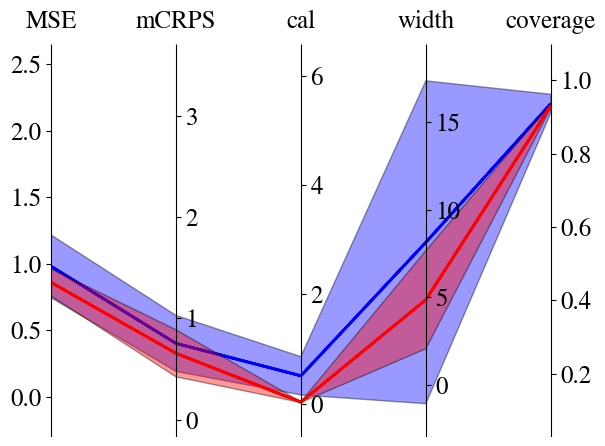

In [41]:
fig, host = plt.subplots()
axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i]) if ymins[i]!=ymaxs[i] else ax.set_ylim(ymins[i]-0.05, ymaxs[i]+0.05)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=18)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
# host.set_title('Parallel Coordinates Plot', fontsize=18)

colors = ['b','b','r','r']
for j in range(0,4,2):

    # create bezier curves for the standard deviations
    lin = np.linspace(0, ys.shape[1] - 1, ys.shape[1] * 3 - 2, endpoint=True)
    verts = np.concatenate([np.stack([  lin, np.repeat(zs[j, :], 3)[1:-1]]).T,
                            np.flip(np.stack([lin, np.repeat(zs[j+1, :], 3)[1:-1]]).T, axis=0),
                            np.asarray([[lin[0], zs[j,0]]])
                            ])
    # straight lines
    lin2 = np.linspace(0, ys.shape[1] - 1, 5, endpoint=True)
    verts2 = np.concatenate([np.stack([lin2, zs[j,:]]).T,
                             np.flip(np.stack([lin2, zs[j+1,:]]).T, axis=0),
                             np.asarray([[lin2[0], zs[j,0]]])
                            ])
    # for x,y in verts2: host.plot(x, y, 'go') # to show the control points of the beziers

    # bezier curves
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO]
    # straight lines
    codes2 = [Path.MOVETO] + [Path.LINETO for _ in range(len(verts2)-1)]

    path = Path(verts2, codes2)

    patch = patches.PathPatch(path, facecolor=colors[j], alpha=0.4, lw=1, edgecolor=None)
    host.add_patch(patch)

    # add mean path
    # bezier curves
    mean = np.mean(np.stack([np.repeat(zs[j, :], 3)[1:-1], np.repeat(zs[j+1, :], 3)[1:-1]]),axis=0)
    verts_m = np.concatenate([np.stack([lin, mean]).T,
                            np.flip(np.stack([lin, mean]).T, axis=0),
                            np.asarray([[lin[0], mean[0]]])
                            ])
    # straight lines
    mean2 = np.mean(np.stack([zs[j, :], zs[j+1, :]]),axis=0)
    verts_m2 = np.concatenate([np.stack([lin2, mean2]).T,
                            np.flip(np.stack([lin2, mean2]).T, axis=0),
                            np.asarray([[lin2[0], mean2[0]]])
                            ])
    
    # brezier curves
    codes_m = [Path.MOVETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO]
    # straight lines
    codes_m2 = [Path.MOVETO] + [Path.LINETO for _ in range(int(len(verts2)) - 1)]

    path_m = Path(verts_m2, codes_m2)
    patch_m = patches.PathPatch(path_m, facecolor=None, lw=2, edgecolor=colors[j])
    host.add_patch(patch_m)
plt.tight_layout()
plt.show()

## Pre-calibration only

In [89]:
data2 = dict(list(data.items())[:2])
result = pd.DataFrame.from_dict(data2, orient='index', columns=["MSE","mCRPS","cal","width","coverage"])

In [41]:
result

,MSE,mCRPS,cal,width,coverage
min,0.288365,0.282866,0.032367,1.692585,0.905349
max,0.292810,0.293860,0.042927,1.785618,0.921464


In [4]:
ymins, ymaxs = [], []

In [38]:
ys = result.values
ymin = ys.min(axis=0)
ymax = ys.max(axis=0)

ymins.append(ymin)
ymaxs.append(ymax)

In [39]:
np.stack(ymins).min(axis=0)

array([-0.05066525,  0.15719257, -0.00288734, -1.0694887 ,  0.11797459])

In [40]:
np.stack(ymaxs).max(axis=0)

array([ 2.0936663 ,  3.34700987,  5.90943065, 17.33636337,  0.99890425])

In [90]:
# organize the data
ys = result.values
ynames = result.columns
# ymin = ys.min(axis=0)
# ymaxs = ys.max(axis=0)
ymins = np.array([-0.05066525,  0.15719257, -0.00288734, -1.0694887 ,  0.11797459])
ymaxs = np.array([ 2.0936663 ,  3.34700987,  5.90943065, 17.33636337,  0.99890425])
dys = ymaxs - ymins
for i in range(len(dys)):
    if dys[i]==0:
        dys[i] = 0.05
ymins -= dys * 0.1  # add 20% padding below and above
ymaxs += dys * 0.1
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

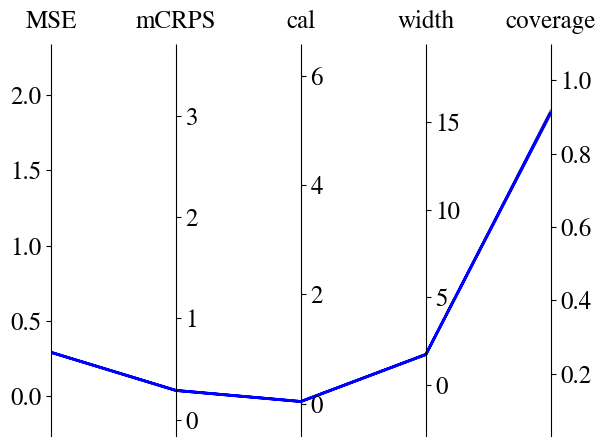

In [91]:
fig, host = plt.subplots()
axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i]) if ymins[i]!=ymaxs[i] else ax.set_ylim(ymins[i]-0.05, ymaxs[i]+0.05)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=18)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()

colors = ['b','b']
for j in range(0,2,2):

    # create bezier curves for the standard deviations
    lin = np.linspace(0, ys.shape[1] - 1, ys.shape[1] * 3 - 2, endpoint=True)
    verts = np.concatenate([np.stack([  lin, np.repeat(zs[j, :], 3)[1:-1]]).T,
                            np.flip(np.stack([lin, np.repeat(zs[j+1, :], 3)[1:-1]]).T, axis=0),
                            np.asarray([[lin[0], zs[j,0]]])
                            ])
    # straight lines
    lin2 = np.linspace(0, ys.shape[1] - 1, 5, endpoint=True)
    verts2 = np.concatenate([np.stack([lin2, zs[j,:]]).T,
                             np.flip(np.stack([lin2, zs[j+1,:]]).T, axis=0),
                             np.asarray([[lin2[0], zs[j,0]]])
                            ])
    # for x,y in verts2: host.plot(x, y, 'go') # to show the control points of the beziers

    # bezier curves
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO]
    # straight lines
    codes2 = [Path.MOVETO] + [Path.LINETO for _ in range(len(verts2)-1)]

    path = Path(verts2, codes2)

    patch = patches.PathPatch(path, facecolor=colors[j], alpha=0.4, lw=1, edgecolor=None)
    host.add_patch(patch)

    # add mean path
    # bezier curves
    mean = np.mean(np.stack([np.repeat(zs[j, :], 3)[1:-1], np.repeat(zs[j+1, :], 3)[1:-1]]),axis=0)
    verts_m = np.concatenate([np.stack([lin, mean]).T,
                            np.flip(np.stack([lin, mean]).T, axis=0),
                            np.asarray([[lin[0], mean[0]]])
                            ])
    # straight lines
    mean2 = np.mean(np.stack([zs[j, :], zs[j+1, :]]),axis=0)
    verts_m2 = np.concatenate([np.stack([lin2, mean2]).T,
                            np.flip(np.stack([lin2, mean2]).T, axis=0),
                            np.asarray([[lin2[0], mean2[0]]])
                            ])
    
    # brezier curves
    codes_m = [Path.MOVETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO]
    # straight lines
    codes_m2 = [Path.MOVETO] + [Path.LINETO for _ in range(int(len(verts2)) - 1)]

    path_m = Path(verts_m2, codes_m2)
    patch_m = patches.PathPatch(path_m, facecolor=None, lw=2, edgecolor=colors[j])
    host.add_patch(patch_m)
plt.tight_layout()
plt.show()

# Training time

In [1]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 18

In [40]:
labels = ['SSVS','MCMC\n(PCA)','MCMC','SVI','QR','dropout']

acea_m = [16557.0740301262,6336.8361373280995,3163.3722030295003,5.1046875,0.5583210318,0.10076277680000176]
acea_s = [4683.745525844296,6411.012320457211,3826.6741536563686,3.159737012518803,0.07906207713350931,0.14014561783585916]

spain_m = [12601.978202305,8049.848172869,2826.4030849603005,2.7558064362000008,2.6920125947999995,0.07675913240000005]
spain_s = [6840.068222259963,4513.276227639548,1734.014522254727,0.1705185812602473,0.13814020546530145,0.13972444008643106]

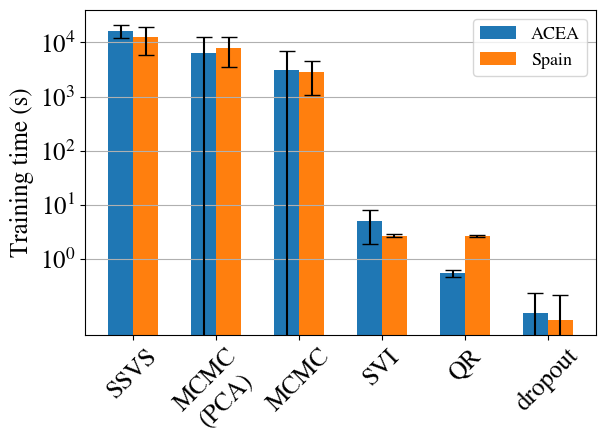

In [45]:
x_pos = [1,2,3,4,5,6]
x_pos1=[0.85,1.85,2.85,3.85,4.85,5.85]
x_pos2=[1.15,2.15,3.15,4.15,5.15,6.15]

fig, ax = plt.subplots()
ax.bar(x_pos1, acea_m, width=0.3, yerr=acea_s, align='center', ecolor='black', capsize=6, log=True, label="ACEA")
ax.bar(x_pos2, spain_m, width=0.3, yerr=spain_s, align='center', ecolor='black', capsize=6, log=True, label="Spain")
ax.set_ylabel('Training time (s)')
ax.set_xticks(x_pos)
ax.set_yticks([1,10,100,1000,10000])
ax.set_xticklabels(labels, rotation=45)
ax.yaxis.grid(True)
plt.legend(loc='best', fontsize=13)

plt.tight_layout()

# Cal vs MSE

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 22

In [2]:
labels = ['SSVS','MCMC (PCA)','MCMC','SVI','QR','dropout']

acea_mse = [1.3611559519786949,0.6151270330230489,0.6853621889462517,0.39351414381897054,0.35119491815567017,0.5786273651142643]
acea_cal = [2.9474652023218946,0.4661018548752834,1.6987378703619616,0.5681579855818824,2.301734022169665,5.455590414514022]

spain_mse = [0.9819395641750092,1.344013064098141,1.02150052606676,0.4532105543146067,0.2905876636505127,0.8638325889008872]
spain_cal = [0.5083413537012437,0.0960364629875618,0.4388813850984182,0.5282984844825502,0.037646799903393355,2.4330950307933827]

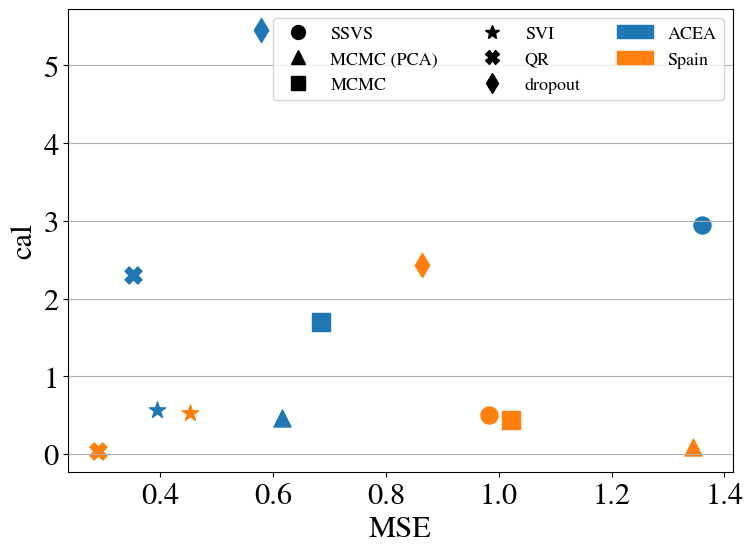

In [10]:
markers = ['o','^','s','*','X','d']

fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(labels)):
    plt.scatter(acea_mse[i], acea_cal[i], marker=markers[i], s=150, c='tab:blue', alpha=1)
    plt.scatter(spain_mse[i], spain_cal[i], marker=markers[i], s=150, c='tab:orange', alpha=1)

    
ax.set_ylabel('cal')
ax.set_xlabel('MSE')
ax.yaxis.grid(True)

patches = []
m_labels = []
for i in range(len(labels)):
    patches.append(plt.Line2D([],[], marker=markers[i], ms=10, c='k', linestyle=''))
    m_labels.append(labels[i])
patches.append(mpatches.Patch(color='tab:blue', label='ACEA'))
patches.append(mpatches.Patch(color='tab:orange', label='Spain'))
m_labels.append('ACEA')
m_labels.append('Spain')

plt.legend(handles=patches, labels=m_labels, loc='best', fontsize=13, ncols=3)
plt.tight_layout()